# 1/15/21 - Starting a master notebook that covers all the steps conducted in previous notebooks.

In [1]:
# libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
import scipy.stats as stats

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
csv_path = '/data/sknabel/autoz_lens_model/files/csv/'
latest_path= f'{csv_path}latest/'
png_path = '/data/sknabel/autoz_lens_model/visuals/png/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'

In [2]:
# load autoz csv
autoz = pd.read_csv(f'{csv_path}autoz.csv')
print(len(autoz))

166332


In [3]:
# load catalogs from LinKS, Li, and Zoo

# load LinKS files from Knabel-2020 (initial and final selections, should be 421 and 47)
links_initial_data = pd.read_csv(f'{knabel2020_file_path}mac_in_gama_withgamaid.csv')
print(len)
# drop null values, objects that didn't match the gama catalog
links = links_initial_data.dropna(axis=0, subset=['GAMA_ID'])
# load the selection from Knabel-2020
links_knabel = pd.read_csv(f'{knabel2020_file_path}mac_latest.csv')

# load Li-2020 files
li_data = pd.read_csv(f'{csv_path}li_match_to_gama_spec.csv')
# drop 0 values, objects that didn't match the gama catalog
li_data.GAMA_ID.replace(0, np.nan, inplace=True)
li = li_data.dropna(axis=0, subset=['GAMA_ID'])

# load Zoo files
zoo = pd.read_csv(f'{knabel2020_file_path}zoo_latest.csv')

print(len(links), len(links_knabel), len(li), len(zoo))

<built-in function len>
305 47 32 13


In [4]:
# merge links catalogs with autoz

links_autoz = pd.merge(links, autoz, how = 'left', on = 'GAMA_ID')
links_knabel_autoz = pd.merge(links_knabel, autoz, how = 'left', on = 'GAMA_ID')
li_autoz = pd.merge(li, autoz, how = 'left', on = 'GAMA_ID')
zoo_autoz = pd.merge(zoo, autoz, how = 'left', on = 'GAMA_ID')

print(len(links_autoz), len(links_knabel_autoz), len(li_autoz), len(zoo_autoz))

348 51 37 13


### Template matches are given as cross-correlation peaks given by their sigma value, with up to four matches.
### We want sigmas 1 and 2 to be significantly higher than sigmas 3 and 4, showing a double spectral profile.
### $R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$

In [5]:
# Select based on R > 1.2
links_select = links_autoz[links_autoz.R > 1.2]
links_knabel_select = links_knabel_autoz[links_knabel_autoz.R > 1.2]
li_select = li_autoz[li_autoz.R > 1.2]
zoo_select = zoo_autoz[zoo_autoz.R > 1.2]
print(len(links_select), len(links_knabel_select), len(li_select), len(zoo_select))

59 7 8 0


Text(0.5, 1.0, 'Selection Based on $\\sigma$ and R Values')

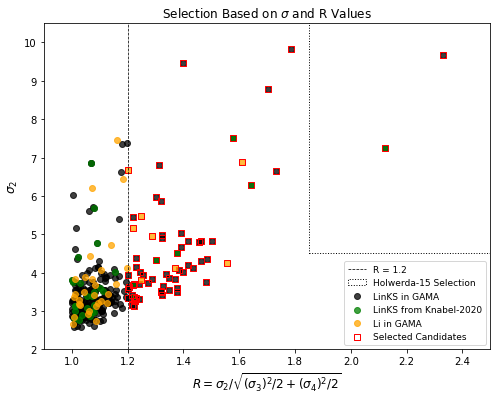

In [6]:
# visualize selection

fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xlim(0.9, 2.5)
ax.set_ylim(2.0, 10.5)
ax.scatter(links_autoz.R,
          links_autoz.sigma2,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_autoz.R,
           links_knabel_autoz.sigma2,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(links_select.R,
          links_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = '_Selected Candidates')
ax.scatter(li_autoz.R,
           li_autoz.sigma2,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
ax.scatter(li_select.R,
          li_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = 'Selected Candidates')
ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
                               edgecolor = 'k', facecolor = 'none', linestyle = ':',
                              label = 'Holwerda-15 Selection'))
ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
plt.legend(fontsize=9)
ax.set_xlabel('$R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$', fontsize = 12)
ax.set_ylabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Selection Based on $\sigma$ and R Values')
#plt.show()

#plt.savefig(f'{png_path}sigma_selection011821.png')

In [102]:
# designate template types (positions of ELGs and/or PGs)
#########
# links
pg_elg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42) 
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_elg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]
elg_pg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42)
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = links_select[(links_select.template2 >= 40) & (links_select.template2 <= 42) & (links_select.template1 >=40 ) & (links_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
elg_elg['type_number'] = 3
pg_pg = links_select[(links_select.template1 > 42) & (links_select.template2 <= 47) & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

links_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_select: {len(links_select_types)}')

##########
#links_knabel
pg_elg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42) 
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_elg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]
elg_pg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42)
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = links_knabel_select[(links_knabel_select.template2 >= 40) & (links_knabel_select.template2 <= 42) & (links_knabel_select.template1 >=40 ) & (links_knabel_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
elg_elg['type_number'] = 3
pg_pg = links_knabel_select[(links_knabel_select.template1 > 42) & (links_knabel_select.template2 <= 47) & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

links_knabel_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_knabel_select: {len(links_knabel_select_types)}')
#############
#li
pg_elg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42) 
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]
pg_elg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]
elg_pg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42)
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = li_select[(li_select.template1 > 42) & (li_select.template2 <= 47) & (li_select.template2 > 42) & (li_select.template2 <= 47)]
elg_elg['type_number'] = 3
elg_elg['type'] = 'ELG + ELG'
pg_pg = li_select[(li_select.template2 >= 40) & (li_select.template2 <= 42) & (li_select.template1 >=40 ) & (li_select.template1 <= 42)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

li_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'li_select: {len(li_select_types)}')

26
12


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

10
8
links_select: 56
5
1
1
0
links_knabel_select: 7
2
2
4
0
li_select: 8


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

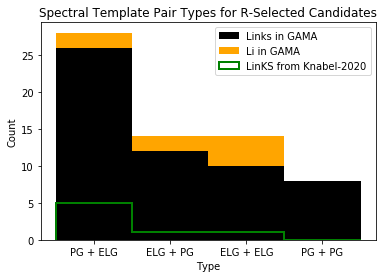

In [137]:
fig, ax = plt.subplots()
ax.hist([links_select_types.type_number, li_select_types.type_number],
        color = ['k','orange'],
         label = ['Links in GAMA', 'Li in GAMA'],
         stacked = True,
       align='mid',
       bins=4,
       range=(0.5, 4.5))
ax.hist([links_knabel_select_types.type_number],
        edgecolor='g',
        histtype='step',
        linewidth=2,
        label='LinKS from Knabel-2020',
        align='mid',
       bins=4,
       range=(0.5, 4.5))#,
        #align='mid')
ax.legend()
ax.set_xlabel('Type')
ax.set_xticks(np.arange(1, 5, 1))
ax.set_xticklabels(['PG + ELG', 'ELG + PG', 'ELG + ELG', 'PG + PG'])
ax.set_ylabel('Count')
ax.set_title('Spectral Template Pair Types for R-Selected Candidates')

#plt.savefig(f'{png_path}template_pair_types_R_selected_012121.png')

Prepare samples for modeling by determining z_lens and z_source (and D_lens and D_source) from z1 and z2, correcting M* for z_lens where Z = z_source $$M_{*correct} = M_* (D_{source}^2/D_{lens}^2)$$

In [105]:
# load lambdar mass catalog
# import lambdarstellarmasses
# Opening GAMA data from G09, G12, and G15 (DR3)
hdul = fits.open('/data/sknabel/autoz_lens_model/files/fits/StellarMassesLambdar.fits')  # open a FITS file
hdul.verify('fix')
masses = hdul[1].data  # assume the first extension is a table
#print(masses.columns)


# create dataframe of masses objects to compare to candidates
GAMA_ID = masses.CATAID.byteswap().newbyteorder()
logmstar = masses.logmstar.byteswap().newbyteorder()
logmintsfh = masses.logmintsfh.byteswap().newbyteorder()
logmremnants = masses.logmremnants.byteswap().newbyteorder()
fluxscale = masses.fluxscale.byteswap().newbyteorder()
dellogmintsfh = masses.dellogmintsfh.byteswap().newbyteorder()
z = masses.Z.byteswap().newbyteorder()

#masses_list = list(zip(GAMA_ID, logmstar, logmintsfh, logmremnants, fluxscale))

#masses_list
lambdar_masses = pd.DataFrame(
    {'GAMA_ID' : GAMA_ID,
#     'logmstar' : logmstar, 
     'lambdar_log_mstar' : logmintsfh,
    'lambdar_mstar' : 10**(logmintsfh),
    'lambdar_log_mstar_error': dellogmintsfh,
    'z': z}
) 
#     'logmremnants' : logmremnants, 
#     'fluxscale' : fluxscale})
lambdar_masses.GAMA_ID = lambdar_masses.GAMA_ID.astype(int)
print(len(lambdar_masses))



120619


In [106]:
# merge with lambdar catalogs
links_lambdar = pd.merge(links_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
links_knabel_lambdar = links_knabel_select_types#pd.merge(links_knabel_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
# note: The csv I used here had already been merged with lambdarmasses
li_lambdar = pd.merge(li_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
print(len(links_lambdar), len(links_knabel_lambdar), len(li_lambdar))
print(links_lambdar.lambdar_log_mstar)

56 7 8
0     11.614862
1     11.421960
2     11.428493
3     11.322670
4     11.662157
5     11.414567
6     11.473941
7     11.485850
8     11.308800
9     11.328982
10    11.553217
11    11.503013
12    11.503013
13    11.285226
14    11.506654
15    11.243180
16    11.623652
17    11.508179
18    11.405825
19    11.668818
20          NaN
21    11.488566
22    11.285226
23    11.489197
24    11.994014
25    11.375979
26    11.760890
27    11.434723
28    11.557787
29    11.472861
30    11.554252
31    11.470999
32    11.738676
33    11.252039
34    11.660450
35    11.510092
36    11.360675
37    11.633840
38    11.630485
39    11.422040
40    11.776137
41    11.252039
42    11.861844
43    11.508821
44    11.709104
45    11.709104
46    11.055600
47    11.528065
48    11.716955
49    11.716750
50    11.351500
51    11.563930
52    11.560124
53    11.486208
54    11.063362
55    11.518801
Name: lambdar_log_mstar, dtype: float32


In [107]:
# label z1 and z2 by the correct zlens and zsource
#links
z1 = links_lambdar.z1
z2 = links_lambdar.z2
z = links_lambdar.z
stellar_mass = links_lambdar.lambdar_mstar
sigma1 = links_lambdar.sigma1
sigma2 = links_lambdar.sigma2

#links_lambdar['zlens'] = 0
#links_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(links_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #links_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #links_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #links_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #links_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
links_lambdar['zlens'] = zlens
links_lambdar['zsource'] = zsource
links_lambdar['sigma_lens'] = sigma_lens
links_lambdar['sigma_source'] = sigma_source
links_lambdar['dlens'] = dlens
links_lambdar['dsource'] = dsource
links_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(links_lambdar.columns)

##########
#links_knabel
# label z1 and z2 by the correct zlens and zsource
z1 = links_knabel_lambdar.z1
z2 = links_knabel_lambdar.z2
z = links_knabel_lambdar.z
stellar_mass = links_knabel_lambdar.lambdar_mstar
sigma1 = links_knabel_lambdar.sigma1
sigma2 = links_knabel_lambdar.sigma2

#links_knabel_lambdar['zlens'] = 0
#links_knabel_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(links_knabel_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #links_knabel_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #links_knabel_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #links_knabel_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #links_knabel_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
links_knabel_lambdar['zlens'] = zlens
links_knabel_lambdar['zsource'] = zsource
links_knabel_lambdar['sigma_lens'] = sigma_lens
links_knabel_lambdar['sigma_source'] = sigma_source
links_knabel_lambdar['dlens'] = dlens
links_knabel_lambdar['dsource'] = dsource
links_knabel_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(links_knabel_lambdar.columns)

################
#li
# label z1 and z2 by the correct zlens and zsource
z1 = li_lambdar.z1
z2 = li_lambdar.z2
z = li_lambdar.z
stellar_mass = li_lambdar.lambdar_mstar
sigma1 = li_lambdar.sigma1
sigma2 = li_lambdar.sigma2

#li_lambdar['zlens'] = 0
#li_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(li_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #li_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #li_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #li_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #li_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
li_lambdar['zlens'] = zlens
li_lambdar['zsource'] = zsource
li_lambdar['sigma_lens'] = sigma_lens
li_lambdar['sigma_source'] = sigma_source
li_lambdar['dlens'] = dlens
li_lambdar['dsource'] = dsource
li_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(li_lambdar.columns)

323152.0 is wonky.
Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'SCORE', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object')
Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'GAMA_ID', 'RA', 'DEC', 'score', 'z',
       'magphys_mstar', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'm_half_re', 'sigma_star', 'D_lens',
       'theta_e_pm', 'theta_e_sis', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'type_number', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object')
Index(['DEC', 'GAMA_ID',

In [108]:
# deal with the wonky one (it doesn't have a lambdar match)
wonky_one = links_lambdar[links_lambdar['GAMA_ID']==323152.0]
wonky_one_index = links_lambdar[links_lambdar['GAMA_ID']==323152.0].index
zl = wonky_one.z2
zs = wonky_one.z1
sigma_l = wonky_one.sigma2
sigma_s = wonky_one.sigma1
dl = cosmo.angular_diameter_distance(zl).value
ds = cosmo.angular_diameter_distance(zs).value


links_lambdar.zlens[links_lambdar.GAMA_ID==323152.0] = zl
links_lambdar.zsource[links_lambdar.GAMA_ID==323152.0] = zs
links_lambdar.sigma_lens[links_lambdar.GAMA_ID==323152.0] = sigma_l
links_lambdar.sigma_source[links_lambdar.GAMA_ID==323152.0] = sigma_s
links_lambdar.dlens[links_lambdar.GAMA_ID==323152.0] = dl
links_lambdar.dsource[links_lambdar.GAMA_ID==323152.0] = ds
print(links_lambdar[links_lambdar.GAMA_ID==323152.0])

/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value 

    Unnamed: 0_x   GAMA_ID      ID         RA      DEC  SCORE  Unnamed: 0_y  \
20             2  323152.0  2967.0  130.54643  1.64325   30.0       38855.0   

         z1    sigma1  template1        z2    sigma2  template2    sigma3  \
20  0.72159  11.31752       47.0  0.353286  7.519264       40.0  4.763242   

      sigma4         R      prob      error      type  type_number  \
20  4.763242  1.578602  0.989458  29.413359  PG + ELG            1   

    lambdar_log_mstar  lambdar_mstar  lambdar_log_mstar_error   z     zlens  \
20                NaN            NaN                      NaN NaN  0.353286   

    zsource  sigma_lens  sigma_source       dlens      dsource  \
20  0.72159    7.519264      11.31752  981.871392  1440.995427   

    corrected_stellar_mass  
20                     NaN  


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


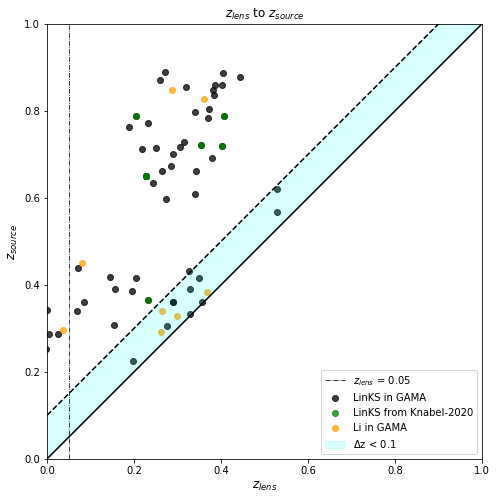

In [109]:
# check lens and source redshifts for reasonability
# plots
x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)
ax.scatter(links_lambdar.zlens,
          links_lambdar.zsource,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_lambdar.zlens,
           links_knabel_lambdar.zsource,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(li_lambdar.zlens,
           li_lambdar.zsource,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_xlabel('$z_{lens}$', fontsize = 12)
ax.set_ylabel('$z_{source}$',  fontsize = 12)
ax.set_title('$z_{lens}$ to $z_{source}$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)
ax.plot(x, x, color = 'k', linestyle = '-')
ax.plot(x, x + 0.1, color = 'k', linestyle = '--')
#ax.plot(x, x - 0.1, color = 'k', linestyle = '--')
plt.fill_between(x, x, x+0.1, # Fill region for false candidates
                 facecolor="cyan", # The fill color
                 color='cyan',       # The outline color
                 alpha=0.15, # Transparency of the fill
                label='$\Delta$z < 0.1') # plots
x = np.linspace(0, 1, 100)


#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)

#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
ax.axvline(0.05, color = 'k', linewidth = .75, linestyle = '-.', label = '$z_{lens}$ = 0.05')

plt.legend()
#plt.show()

#plt.savefig(f'{png_path}zlens_to_zsource_011821.png')


In [110]:
# take candidates with z_lens > 0.05 and delta-z > 0.1
li_redshift_cut = li_lambdar[(li_lambdar.zsource - li_lambdar.zlens > 0.1) 
                             & (li_lambdar.zlens > 0.05)]
links_redshift_cut = links_lambdar[(links_lambdar.zsource - links_lambdar.zlens > 0.1) 
                                   & (links_lambdar.zlens > 0.05)]
links_knabel_redshift_cut = links_knabel_lambdar[(links_knabel_lambdar.zsource - links_knabel_lambdar.zlens > 0.1) 
                                                 & (links_knabel_lambdar.zlens > 0.05)]

print(len(li_lambdar), len(links_lambdar), len(links_knabel_lambdar))
print(len(li_redshift_cut), len(links_redshift_cut), len(links_knabel_redshift_cut))
#print(li_lambdar.zlens, links_lambdar.zlens, links_knabel_lambdar.zlens)
#print(li_redshift_cut.zlens, links_redshift_cut.zlens, links_knabel_redshift_cut.zlens)

8 56 7
3 42 7


In [111]:
# examine duplicates in links
links_duplicates = links_redshift_cut[links_redshift_cut.duplicated(subset=['GAMA_ID'], keep=False)]
print(links_duplicates)
links_knabel_duplicates = links_knabel_redshift_cut[links_knabel_redshift_cut.GAMA_ID.duplicated(keep=False)]
print(links_knabel_duplicates)

    Unnamed: 0_x   GAMA_ID      ID         RA      DEC  SCORE  Unnamed: 0_y  \
13           316  544226.0  3212.0  214.42336 -0.89247   18.0       94759.0   
22           316  544226.0  3212.0  214.42336 -0.89247   18.0      154300.0   
33           329  262874.0    26.0  221.61067  2.22389   12.0      159395.0   
41           329  262874.0    26.0  221.61067  2.22389   12.0      139125.0   

          z1    sigma1  template1        z2    sigma2  template2    sigma3  \
13  0.227044  9.393048       40.0  0.649824  7.239896       46.0  3.411552   
22  0.649852  6.409822       47.0  0.227039  6.293928       40.0  3.835091   
33  0.385518  9.339182       40.0  0.194628  4.816656       47.0  3.402748   
41  0.385581  6.221604       40.0  0.858924  3.421708       41.0  2.811662   

      sigma4         R      prob      error       type  type_number  \
13  3.411552  2.122170  0.996206  45.355965   PG + ELG            1   
22  3.835091  1.641142  0.366429  39.200554   PG + ELG            1   


### G544226 has two entries.
    Each show PG at z=0.22 and ELG at z=0.65.
    Cross-correlation sigma is higher for each for the one indexed at 13 (48 in knabel), as is R.
    Index 22 shows a higher sigma for the source than the lens, in effect getting them backwards.
    For the above reasons I will keep Index 13 (48).
### G262874 has two entries.
    Both show z1 to be a PG at z=0.38.
    Index 33 shows the second match at closer redshift as an ELG+PG.
    Index 41 is the more reasonable one.

In [112]:
links_dropped_duplicates = links_redshift_cut.drop(index=[22, 33])
links_knabel_dropped_duplicates = links_knabel_redshift_cut.drop(index=[49])
print(len(links_dropped_duplicates), len(links_knabel_dropped_duplicates))

40 6


### This is the most recent selection of candidate lenses, including cuts based on autoz output, redshifts, and duplicates.
### LinKS: 40 (including 6 from Knabel-2020)
### Li: 3
## Total of 43 candidates to pursue.

In [113]:
# Reassign consistent naming scheme, reset indices
links_selected_sample = links_dropped_duplicates.reset_index(drop=True)
links_selected_sample.rename(columns={'SCORE':'score'}, inplace=True)
links_knabel_selected_sample = links_knabel_dropped_duplicates.reset_index(drop=True)
li_selected_sample = li_redshift_cut.reset_index(drop=True)


print(len(links_selected_sample), len(links_knabel_selected_sample), len(li_selected_sample))
print(links_selected_sample.columns, 
      links_knabel_selected_sample.columns, 
      li_selected_sample.columns)
print(links_selected_sample, links_knabel_selected_sample, li_selected_sample)

40 6 3
Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object') Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'GAMA_ID', 'RA', 'DEC', 'score', 'z',
       'magphys_mstar', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'm_half_re', 'sigma_star', 'D_lens',
       'theta_e_pm', 'theta_e_sis', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'type_number', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object') Index(['DEC', 'GAMA_ID', 'KIDS_ID', 

### Visualization

Text(0.5, 1.0, 'Redshift Success Probability')

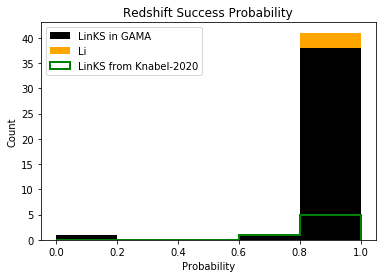

In [114]:
# redshift success probability
plt.hist([links_selected_sample.prob, li_selected_sample.prob],
        color = ['k', 'orange'],
         label = ['LinKS in GAMA', 'Li'],
         stacked = True,
        bins=np.linspace(0,1,6))#, density = True)
plt.hist(links_knabel_selected_sample.prob,
        color = 'g',
         label = 'LinKS from Knabel-2020',
        histtype='step',
         linewidth=2,
        bins=np.linspace(0,1,6))#, density = True)
plt.legend(),
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Redshift Success Probability')

#plt.savefig(f'{png_path}z_success_probability_011821.png')

In [115]:
# Drop the one very low probability redshift match
links_selected_sample = links_selected_sample[(links_selected_sample.prob>0.5)]
links_selected_sample = links_selected_sample.reset_index(drop=True)
print(len(links_selected_sample))
print(links_selected_sample.columns)


39
Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object')


# We now are working with 39(6) and 3, total of 42.

### Apply correlation tests (Spearman, Pearson, and Kendall) for autoz output and lens scores.
Spearman ranking - monotonic

Pearson ranking - linear

Kendall Tau - monotonic

### Bring back in the raw LinKS data.

In [116]:
# forgive this messy code....
# match back to raw links_table (because I didn't use all the parameters in the 2020 paper)
links_raw = pd.read_csv(f'{knabel2020_file_path}linkstable_trimmed.csv')
print(links_raw.columns)

Index(['ID', 'score', 'P1', 'P3', 'RA', 'DEC', 'DISC'], dtype='object')


In [117]:
# match on RA/Dec (I should have left the LinKS Identifier...)
for i in range(len(links_selected_sample)):
    for j in range(len(links_raw)):
        b = 2./3600
        dRA = links_selected_sample.RA.iloc[i] - links_raw.RA.iloc[j]
        dDec = links_selected_sample.DEC.iloc[i] - links_raw.DEC.iloc[j]
        r = np.sqrt(dRA**2 + dDec**2)
        if r <= b:
            index=j
            b = r
    links_selected_sample['ID'].iloc[i] = links_raw.ID.iloc[index] 
links_selected_sample.ID = links_selected_sample.ID.astype('int64')
#print(links_selected_sample.ID.dtype)
#print(links_raw.ID)
links_selected_sample_with_cnn_prob = pd.merge(links_selected_sample, links_raw[['ID','P1','P3']], 
                                               on='ID', how='left')
links_knabel_selected_sample_with_ID = pd.merge(links_knabel_selected_sample, links_selected_sample[['GAMA_ID','ID']], 
                                                on='GAMA_ID', how='left')
links_knabel_selected_sample_with_cnn_prob = pd.merge(links_knabel_selected_sample_with_ID, links_raw[['ID','P1','P3']], 
                                                      on='ID', how='left')
print(links_selected_sample_with_cnn_prob[['P1','P3']])
print(links_knabel_selected_sample_with_cnn_prob[['P1','P3']])

/soft/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


       P1     P3
0   0.832    NaN
1   0.901    NaN
2   0.876    NaN
3   0.895    NaN
4   0.909    NaN
5   0.837    NaN
6     NaN  0.980
7   0.890  0.981
8   0.994  0.990
9     NaN  0.812
10    NaN  0.912
11  0.988    NaN
12  0.812    NaN
13    NaN  0.862
14    NaN  0.895
15    NaN  0.964
16  0.903    NaN
17  0.999  1.000
18  1.000  1.000
19  0.929    NaN
20  0.929    NaN
21  0.843    NaN
22  0.855  0.960
23  0.997    NaN
24  0.975  0.826
25  0.820    NaN
26    NaN  0.883
27  0.906  0.807
28  0.997  0.959
29    NaN  0.986
30  0.968  0.975
31  0.887  0.990
32  0.980  0.931
33  0.866    NaN
34  0.843    NaN
35  0.975  0.986
36  0.892    NaN
37  0.959    NaN
38  0.824  0.961
      P1     P3
0  0.837    NaN
1  0.988    NaN
2  0.999  1.000
3  1.000  1.000
4  0.929    NaN
5    NaN  0.883


In [118]:
# rename back to the selected sample
links_selected_sample = links_selected_sample_with_cnn_prob
links_knabel_selected_sample = links_knabel_selected_sample_with_cnn_prob
print(links_selected_sample.columns)

Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass', 'P1', 'P3'],
      dtype='object')


In [119]:
# make new column to normalize scores to [0, 1]
links_selected_sample['normalized_score'] = links_selected_sample.score/70.
links_knabel_selected_sample['normalized_score'] = links_knabel_selected_sample.score/70.
li_selected_sample['normalized_score'] = li_selected_sample.score/10.

#print(links_selected_sample.normalized_score, li_selected_sample.normalized_score)

# make new column that is best probability measurement
# for links
links_selected_sample["cnn_probability"] = np.zeros(len(links_selected_sample))

for i in range(len(links_selected_sample)):
    probabilities = np.nan_to_num([links_selected_sample.P1[i], links_selected_sample.P3[i]])#, samples.prob[i]])
    print((probabilities))
    links_selected_sample['cnn_probability'][i] = np.max(probabilities)

# for links_knabel
links_knabel_selected_sample["cnn_probability"] = np.zeros(len(links_knabel_selected_sample))

for i in range(len(links_knabel_selected_sample)):
    probabilities = np.nan_to_num([links_knabel_selected_sample.P1[i], links_knabel_selected_sample.P3[i]])#, samples.prob[i]])
    print((probabilities))
    links_knabel_selected_sample['cnn_probability'][i] = np.max(probabilities)
                                   
# for li
li_selected_sample["cnn_probability"] = li_selected_sample.prob            

# merge to one catalog for correlation tests
samples = pd.concat([links_selected_sample, li_selected_sample])
samples = samples.reset_index(drop=True)
#samples.drop(columns={'index'}, inplace=True)
print(samples.columns, len(samples))
      
samples["cnn_probability"]

# save these to the latest output
links_selected_sample.to_csv(f'{csv_path}links_sample_012121_len39.csv')
links_selected_sample.to_csv(f'{latest_path}links_sample_latest.csv')
links_knabel_selected_sample.to_csv(f'{csv_path}links_knabel_sample_012121_len6.csv')
links_knabel_selected_sample.to_csv(f'{latest_path}links_knabel_sample_latest.csv')
li_selected_sample.to_csv(f'{csv_path}li_sample_012121_len3.csv')
li_selected_sample.to_csv(f'{latest_path}li_sample_latest.csv')
samples.to_csv(f'{csv_path}all_samples_012121_len42.csv')
samples.to_csv(f'{latest_path}all_samples_latest.csv')


[0.832 0.   ]
[0.901 0.   ]
[0.876 0.   ]
[0.895 0.   ]
[0.909 0.   ]
[0.837 0.   ]
[0.   0.98]


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


[0.89  0.981]
[0.994 0.99 ]
[0.    0.812]
[0.    0.912]
[0.988 0.   ]
[0.812 0.   ]
[0.    0.862]
[0.    0.895]
[0.    0.964]
[0.903 0.   ]
[0.999 1.   ]
[1. 1.]
[0.929 0.   ]
[0.929 0.   ]
[0.843 0.   ]
[0.855 0.96 ]
[0.997 0.   ]
[0.975 0.826]
[0.82 0.  ]
[0.    0.883]
[0.906 0.807]
[0.997 0.959]
[0.    0.986]
[0.968 0.975]
[0.887 0.99 ]
[0.98  0.931]
[0.866 0.   ]
[0.843 0.   ]
[0.975 0.986]
[0.892 0.   ]
[0.959 0.   ]
[0.824 0.961]
[0.837 0.   ]
[0.988 0.   ]
[0.999 1.   ]
[1. 1.]
[0.929 0.   ]
[0.    0.883]


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Index(['DEC', 'GAMA_ID', 'ID', 'KIDS_ID', 'P1', 'P3', 'R', 'RA',
       'Unnamed: 0_x', 'Unnamed: 0_y', 'cnn_probability',
       'corrected_stellar_mass', 'dlens', 'dsource', 'error',
       'lambdar_log_mstar', 'lambdar_log_mstar_error', 'lambdar_mstar', 'mag',
       'mag_err', 'name', 'normalized_score', 'num_0', 'prob', 'probability',
       'rms', 's*p/10', 'score', 'sigma1', 'sigma2', 'sigma3', 'sigma4',
       'sigma_lens', 'sigma_source', 'template1', 'template2', 'type',
       'type_number', 'z', 'z1', 'z2', 'z_max', 'z_min', 'zlens', 'zphot',
       'zsource'],
      dtype='object') 42


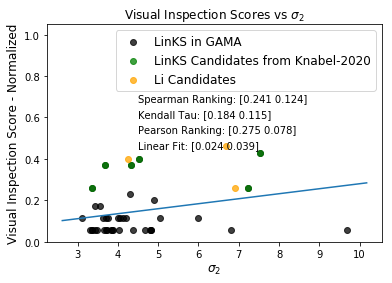

In [120]:
# visual inspection score to sigma2

spear = np.around(stats.spearmanr(samples.normalized_score, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.sigma2)[:], 3)

# fit a line
model = np.polyfit(samples.sigma2, samples.normalized_score, 1)
x = np.linspace(np.min(samples.sigma2) - 0.5, np.max(samples.sigma2) + 0.5, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(#links.R,
          links_selected_sample.sigma2,
    links_selected_sample.normalized_score,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(#links_identified.R,
           links_knabel_selected_sample.sigma2,
    links_knabel_selected_sample.normalized_score,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(#li.R,
           li_selected_sample.sigma2,
    li_selected_sample.normalized_score,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman Ranking: {spear}', (4.5, 0.675))
plt.annotate(f'Kendall Tau: {kendall}', (4.5, 0.6))
plt.annotate(f'Pearson Ranking: {pears}', (4.5, 0.525))
plt.annotate(f'Linear Fit: {np.around(model, 3)}', (4.5, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs $\sigma_2$')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}visual_score_to_sigma2_012121.png')

[array([0.241, 0.124]), array([0.275, 0.078]), array([0.184, 0.115]), array([0.02412814, 0.03865822])]
mean, std 0.0272063146916576 0.016920711554324324
mean, std 0.025407138111300773 0.07127593407583728


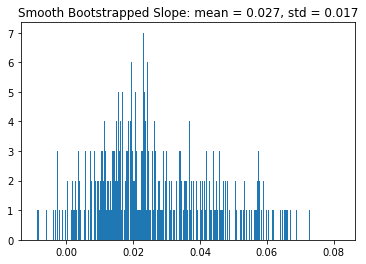

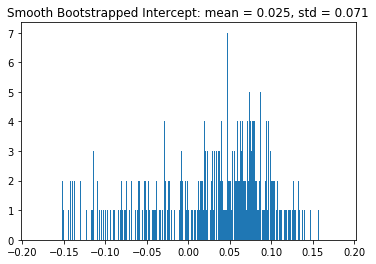

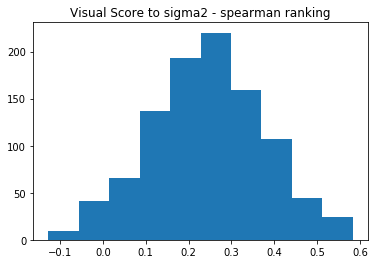

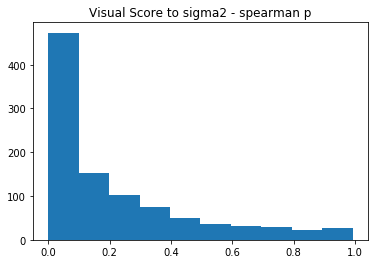

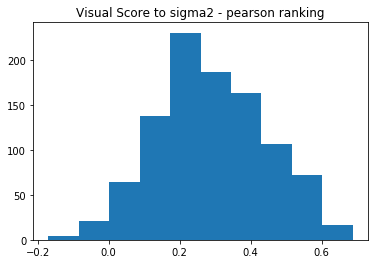

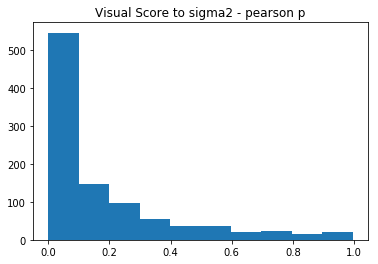

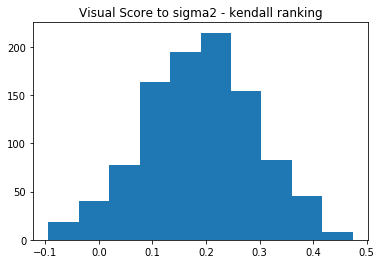

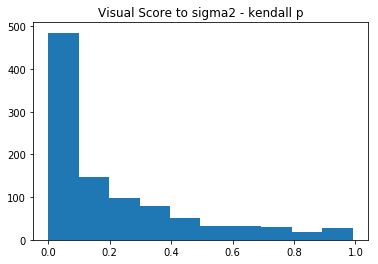

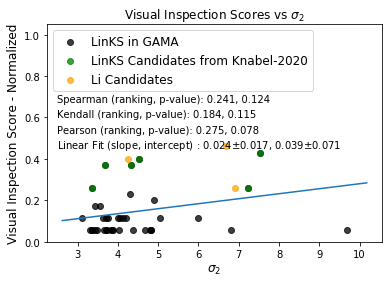

In [121]:
# run bootstrapping to see how the rankings change for normalized_score to sigma2 and R
# sigma2

# create array to show stats (columns=spearman ranking, p,pearson ranking, p,kendall ranking, p), 42 iterations
bootstrapping_sigma2 = np.zeros((1000, 8), dtype=float)

#print(bootstrapping_sigma2)

spear = np.around(stats.spearmanr(samples.normalized_score, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.sigma2)[:], 3)
linear = np.polyfit(samples.sigma2, samples.normalized_score, 1)

full_sample=[spear, pears, kendall, linear]
print(full_sample)

# take random samples of 30, omit 12 and replace with values from the 30
for i in range(1000):
    # shuffle the sample
    indices = np.arange(len(samples))
    #print(indices)
    np.random.shuffle(indices)
    #print(indices)
    subsample_index = indices[:30]
    #print(len(np.unique(subsample_index)))
    bootstrap_index = np.random.choice(subsample_index, 12) # subsample 12 from subsample
    new_sample_index = np.concatenate((subsample_index, bootstrap_index)) # concat to new sample
    new_sample = samples.iloc[new_sample_index]
    # smooth x-values (sigma2) using random gaussian
    #print(new_sample.sigma2)
    #print(new_sample)
    
    # run tests
    spear = np.around(stats.spearmanr(new_sample.normalized_score, new_sample.sigma2)[:], 3)
    pears = np.around(stats.pearsonr(new_sample.normalized_score, new_sample.sigma2)[:], 3)
    kendall = np.around(stats.kendalltau(new_sample.normalized_score, new_sample.sigma2)[:], 3)
    linear = np.around(np.polyfit(new_sample.sigma2, new_sample.normalized_score, 1)[:], 3)
    #print(linear)
    #print(new_sample[['sigma2', 'normalized_score']])
    #print(linear)
    bootstrapping_sigma2[i] = (spear[0], spear[1], 
                               pears[0], pears[1], 
                               kendall[0], kendall[1],
                              linear[0], linear[1])
    smoothed_slopes = bootstrapping_sigma2[:,6] + np.random.normal(loc=0.0, scale=0.001, size=1000)
    smoothed_intercepts = bootstrapping_sigma2[:,7] + np.random.normal(loc=0.0, scale=0.001, size=1000) 
#print(bootstrapping_sigma2)
#print(bootstrapping_sigma2[:,6:])
fig, ax = plt.subplots()
ax.hist(smoothed_slopes, bins=1000)#, normed=True)
ax.set_title(f'Smooth Bootstrapped Slope: mean = {np.around(np.mean(smoothed_slopes), 3)}, std = {np.around(np.std(smoothed_slopes), 3)}')
print('mean, std', np.mean(smoothed_slopes), np.std(smoothed_slopes))
fig, ax = plt.subplots()
ax.hist(smoothed_intercepts, bins=1000)
ax.set_title(f'Smooth Bootstrapped Intercept: mean = {np.around(np.mean(smoothed_intercepts), 3)}, std = {np.around(np.std(smoothed_intercepts), 3)}')
print('mean, std', np.mean(smoothed_intercepts), np.std(smoothed_intercepts))
plt.figure()
plt.hist(bootstrapping_sigma2[:,0], bins = 10)
plt.title('Visual Score to sigma2 - spearman ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,1], bins=10)
plt.title('Visual Score to sigma2 - spearman p')
plt.figure()
plt.hist(bootstrapping_sigma2[:,2], bins = 10)
plt.title('Visual Score to sigma2 - pearson ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,3], bins=10)
plt.title('Visual Score to sigma2 - pearson p')
plt.figure()
plt.hist(bootstrapping_sigma2[:,4], bins = 10)
plt.title('Visual Score to sigma2 - kendall ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,5], bins=10)
plt.title('Visual Score to sigma2 - kendall p')


# visual inspection score to sigma2

spear = np.around(stats.spearmanr(samples.normalized_score, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.sigma2)[:], 3)

# fit a line
model = np.polyfit(samples.sigma2, samples.normalized_score, 1)
x = np.linspace(np.min(samples.sigma2) - 0.5, np.max(samples.sigma2) + 0.5, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(#links.R,
          links_selected_sample.sigma2,
    links_selected_sample.normalized_score,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(#links_identified.R,
           links_knabel_selected_sample.sigma2,
    links_knabel_selected_sample.normalized_score,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(#li.R,
           li_selected_sample.sigma2,
    li_selected_sample.normalized_score,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman (ranking, p-value): {spear[0]}, {spear[1]}', (2.5, 0.675))
plt.annotate(f'Kendall (ranking, p-value): {kendall[0]}, {kendall[1]}', (2.5, 0.6))
plt.annotate(f'Pearson (ranking, p-value): {pears[0]}, {pears[1]}', (2.5, 0.525))
plt.annotate(f'Linear Fit (slope, intercept) : {np.around(model[0], 3)}$\\pm${np.around(np.std(smoothed_slopes), 3)}, '\
                f'{np.around(model[1], 3)}$\\pm${np.around(np.std(smoothed_intercepts), 3)}', (2.5, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs $\sigma_2$')
plt.legend(fontsize=12, loc='upper left')
#plt.show()

#plt.savefig(f'{png_path}visual_score_to_sigma2_012121.png')

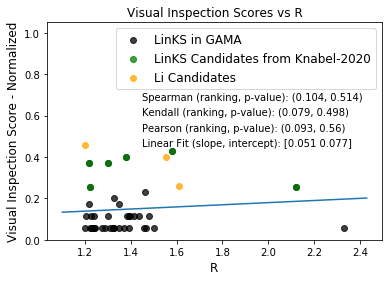

In [122]:
# visual inspection score to R

spear = np.around(stats.spearmanr(samples.normalized_score, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.R)[:], 3)

# fit a line
model = np.polyfit(samples.R, samples.normalized_score, 1)
x = np.linspace(np.min(samples.R) - 0.1, np.max(samples.R) + 0.1, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(#links.R,
          links_selected_sample.R,
    links_selected_sample.normalized_score,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(#links_identified.R,
           links_knabel_selected_sample.R,
    links_knabel_selected_sample.normalized_score,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(#li.R,
           li_selected_sample.R,
    li_selected_sample.normalized_score,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman (ranking, p-value): ({spear[0]}, {spear[1]})', (1.45, 0.675))
plt.annotate(f'Kendall (ranking, p-value): ({kendall[0]}, {kendall[1]})', (1.45, 0.6))
plt.annotate(f'Pearson (ranking, p-value): ({pears[0]}, {pears[1]})', (1.45, 0.525))
plt.annotate(f'Linear Fit (slope, intercept): {np.around(model, 3)}', (1.45, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('R',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}visual_score_to_R_011821.png')

[array([0.104, 0.514]), array([0.093, 0.56 ]), array([0.079, 0.498]), array([0.05146148, 0.07657482])]
mean, std 0.07061688906512499 0.09900673260450003
mean, std 0.051325105890577316 0.13539399847385075


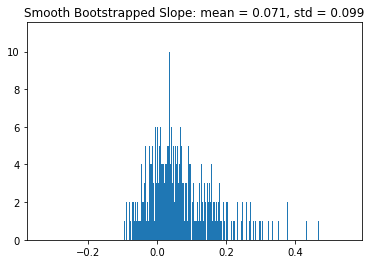

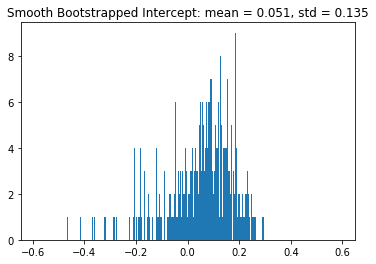

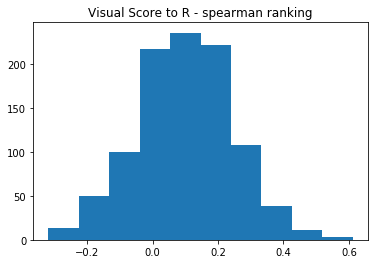

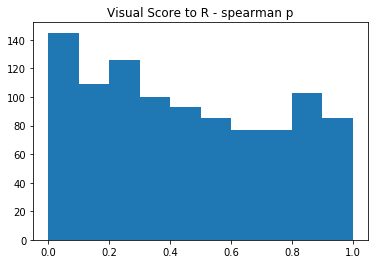

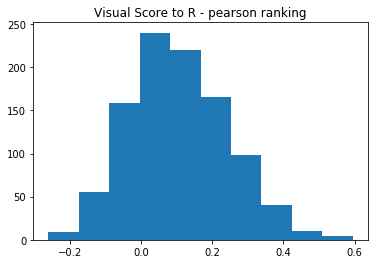

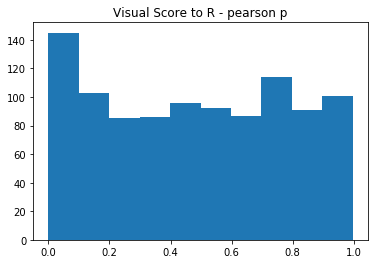

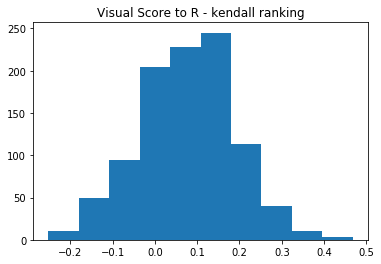

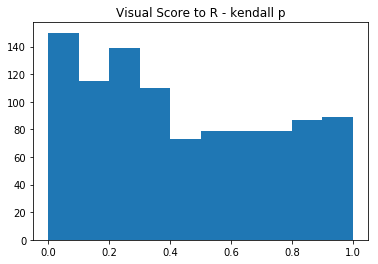

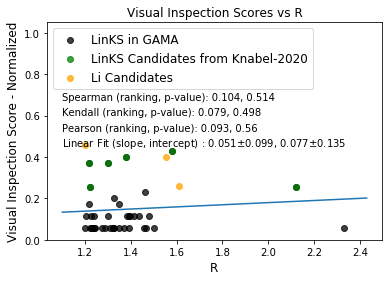

In [123]:
# run bootstrapping to see how the rankings change for normalized_score to sigma2 and R
# R

# create array to show stats (columns=spearman ranking, p,pearson ranking, p,kendall ranking, p), 42 iterations
bootstrapping_R = np.zeros((1000, 8), dtype=float)

#print(bootstrapping_R)

spear = np.around(stats.spearmanr(samples.normalized_score, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.R)[:], 3)
linear = np.polyfit(samples.R, samples.normalized_score, 1)

full_sample=[spear, pears, kendall, linear]
print(full_sample)

# take random samples of 30, omit 12 and replace with values from the 30
for i in range(1000):
    # shuffle the sample
    indices = np.arange(len(samples))
    #print(indices)
    np.random.shuffle(indices)
    #print(indices)
    subsample_index = indices[:30]
    #print(len(np.unique(subsample_index)))
    bootstrap_index = np.random.choice(subsample_index, 12) # subsample 12 from subsample
    new_sample_index = np.concatenate((subsample_index, bootstrap_index)) # concat to new sample
    new_sample = samples.iloc[new_sample_index]
    # smooth x-values (R) using random gaussian
    #print(new_sample.R)
    #print(new_sample)
    
    # run tests
    spear = np.around(stats.spearmanr(new_sample.normalized_score, new_sample.R)[:], 3)
    pears = np.around(stats.pearsonr(new_sample.normalized_score, new_sample.R)[:], 3)
    kendall = np.around(stats.kendalltau(new_sample.normalized_score, new_sample.R)[:], 3)
    linear = np.around(np.polyfit(new_sample.R, new_sample.normalized_score, 1)[:], 3)
    #print(linear)
    #print(new_sample[['R', 'normalized_score']])
    #print(linear)
    bootstrapping_R[i] = (spear[0], spear[1], 
                               pears[0], pears[1], 
                               kendall[0], kendall[1],
                              linear[0], linear[1])
    smoothed_slopes = bootstrapping_R[:,6] + np.random.normal(loc=0.0, scale=0.001, size=1000)
    smoothed_intercepts = bootstrapping_R[:,7] + np.random.normal(loc=0.0, scale=0.001, size=1000) 
#print(bootstrapping_R)
#print(bootstrapping_R[:,6:])
fig, ax = plt.subplots()
ax.hist(smoothed_slopes, bins=1000)#, normed=True)
ax.set_title(f'Smooth Bootstrapped Slope: mean = {np.around(np.mean(smoothed_slopes), 3)}, std = {np.around(np.std(smoothed_slopes), 3)}')
print('mean, std', np.mean(smoothed_slopes), np.std(smoothed_slopes))
fig, ax = plt.subplots()
ax.hist(smoothed_intercepts, bins=1000)
ax.set_title(f'Smooth Bootstrapped Intercept: mean = {np.around(np.mean(smoothed_intercepts), 3)}, std = {np.around(np.std(smoothed_intercepts), 3)}')
print('mean, std', np.mean(smoothed_intercepts), np.std(smoothed_intercepts))

plt.figure()
plt.hist(bootstrapping_R[:,0], bins = 10)
plt.title('Visual Score to R - spearman ranking')
plt.figure()
plt.hist(bootstrapping_R[:,1], bins=10)
plt.title('Visual Score to R - spearman p')
plt.figure()
plt.hist(bootstrapping_R[:,2], bins = 10)
plt.title('Visual Score to R - pearson ranking')
plt.figure()
plt.hist(bootstrapping_R[:,3], bins=10)
plt.title('Visual Score to R - pearson p')
plt.figure()
plt.hist(bootstrapping_R[:,4], bins = 10)
plt.title('Visual Score to R - kendall ranking')
plt.figure()
plt.hist(bootstrapping_R[:,5], bins=10)
plt.title('Visual Score to R - kendall p')

spear = np.around(stats.spearmanr(samples.normalized_score, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.normalized_score, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.normalized_score, samples.R)[:], 3)

# fit a line
model = np.polyfit(samples.R, samples.normalized_score, 1)
x = np.linspace(np.min(samples.R) - 0.1, np.max(samples.R) + 0.1, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(#links.R,
          links_selected_sample.R,
    links_selected_sample.normalized_score,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(#links_identified.R,
           links_knabel_selected_sample.R,
    links_knabel_selected_sample.normalized_score,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(#li.R,
           li_selected_sample.R,
    li_selected_sample.normalized_score,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman (ranking, p-value): {spear[0]}, {spear[1]}', (1.1, 0.675))
plt.annotate(f'Kendall (ranking, p-value): {kendall[0]}, {kendall[1]}', (1.1, 0.6))
plt.annotate(f'Pearson (ranking, p-value): {pears[0]}, {pears[1]}', (1.1, 0.525))
plt.annotate(f'Linear Fit (slope, intercept) : {np.around(model[0], 3)}$\\pm${np.around(np.std(smoothed_slopes), 3)}, '\
                f'{np.around(model[1], 3)}$\\pm${np.around(np.std(smoothed_intercepts), 3)}', (1.1, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('R',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs R')
plt.legend(fontsize=12, loc='upper left')
#plt.show()

#plt.savefig(f'{png_path}visual_score_to_R_012121.png')

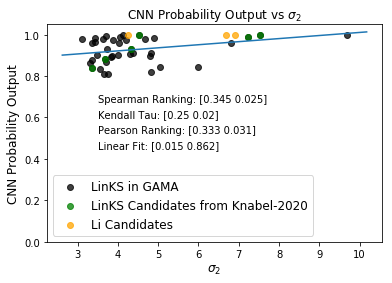

In [124]:
# CNN probability score vs sigma2


# statistical tests of correlation
spear = np.around(stats.spearmanr(samples.cnn_probability, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.sigma2)[:], 3)

# fit a line
model = np.polyfit(samples.sigma2, samples.cnn_probability, 1)
x = np.linspace(np.min(samples.sigma2) - 0.5, np.max(samples.sigma2) + 0.5, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.sigma2,
          #links.sigma2,
    links_selected_sample.cnn_probability,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.sigma2,
           #links_knabel.sigma2,
    links_knabel_selected_sample.cnn_probability,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(li_selected_sample.sigma2,
           #li.sigma2,
    li_selected_sample.probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman Ranking: {spear}', (3.5, 0.675))
plt.annotate(f'Kendall Tau: {kendall}', (3.5, 0.6))
plt.annotate(f'Pearson Ranking: {pears}', (3.5, 0.525))
plt.annotate(f'Linear Fit: {np.around(model, 3)}', (3.5, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$\sigma_2$',  fontsize = 12)
ax.set_title('CNN Probability Output vs $\sigma_2$')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}cnn_score_to_sigma2_011821.png')

[array([0.345, 0.025]), array([0.333, 0.031]), array([0.25, 0.02]), array([0.01484438, 0.86207014])]
mean, std 0.014989672204595796 0.004279187146383694
mean, std 0.8612348941209673 0.021524318439438837


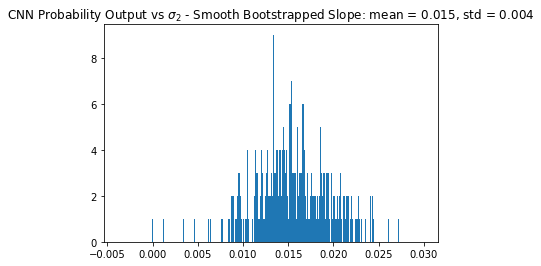

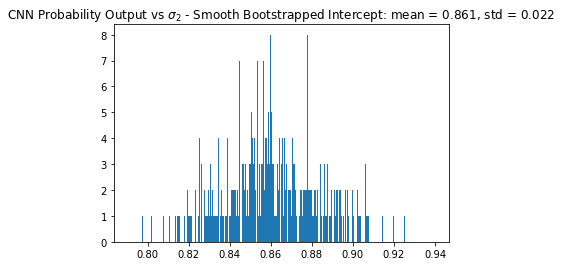

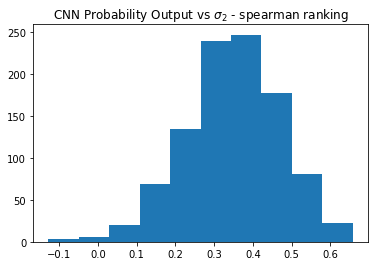

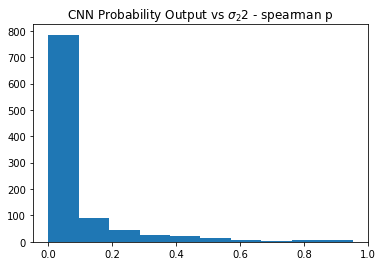

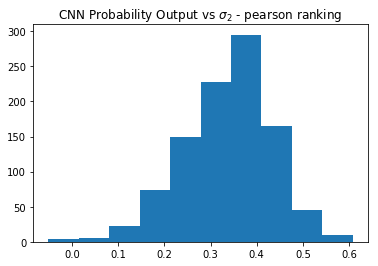

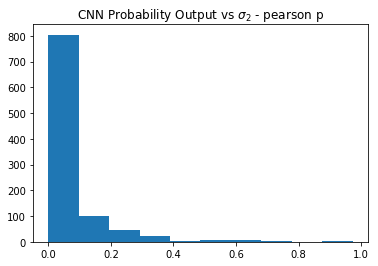

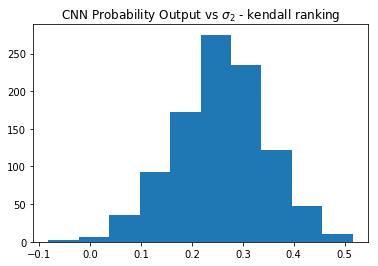

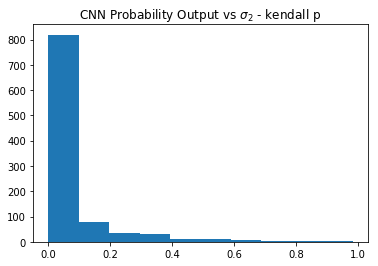

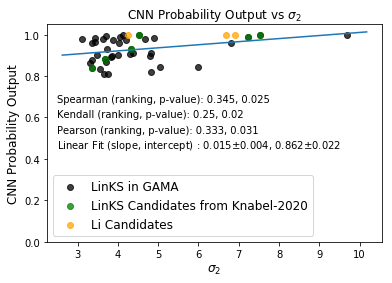

In [125]:
# run bootstrapping to see how the rankings change for cnn_probability to sigma2 and R
# sigma2

# create array to show stats (columns=spearman ranking, p,pearson ranking, p,kendall ranking, p), 42 iterations
bootstrapping_sigma2 = np.zeros((1000, 8), dtype=float)

#print(bootstrapping_sigma2)

spear = np.around(stats.spearmanr(samples.cnn_probability, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.sigma2)[:], 3)
linear = np.polyfit(samples.sigma2, samples.cnn_probability, 1)

full_sample=[spear, pears, kendall, linear]
print(full_sample)

# take random samples of 30, omit 12 and replace with values from the 30
for i in range(1000):
    # shuffle the sample
    indices = np.arange(len(samples))
    #print(indices)
    np.random.shuffle(indices)
    #print(indices)
    subsample_index = indices[:30]
    #print(len(np.unique(subsample_index)))
    bootstrap_index = np.random.choice(subsample_index, 12) # subsample 13 from subsample
    new_sample_index = np.concatenate((subsample_index, bootstrap_index)) # concat to new sample
    new_sample = samples.iloc[new_sample_index]
    # smooth x-values (sigma2) using random gaussian
    #print(new_sample.sigma2)
    #print(new_sample)
    
    # run tests
    spear = np.around(stats.spearmanr(new_sample.cnn_probability, new_sample.sigma2)[:], 3)
    pears = np.around(stats.pearsonr(new_sample.cnn_probability, new_sample.sigma2)[:], 3)
    kendall = np.around(stats.kendalltau(new_sample.cnn_probability, new_sample.sigma2)[:], 3)
    linear = np.around(np.polyfit(new_sample.sigma2, new_sample.cnn_probability, 1)[:], 3)
    #print(linear)
    #print(new_sample[['sigma2', 'cnn_probability']])
    #print(linear)
    bootstrapping_sigma2[i] = (spear[0], spear[1], 
                               pears[0], pears[1], 
                               kendall[0], kendall[1],
                              linear[0], linear[1])
    smoothed_slopes = bootstrapping_sigma2[:,6] + np.random.normal(loc=0.0, scale=0.001, size=1000)
    smoothed_intercepts = bootstrapping_sigma2[:,7] + np.random.normal(loc=0.0, scale=0.001, size=1000) 
#print(bootstrapping_sigma2)
#print(bootstrapping_sigma2[:,6:])
fig, ax = plt.subplots()
ax.hist(smoothed_slopes, bins=1000)#, normed=True)
ax.set_title(f'CNN Probability Output vs $\sigma_2$ - Smooth Bootstrapped Slope: mean = {np.around(np.mean(smoothed_slopes), 3)}, std = {np.around(np.std(smoothed_slopes), 3)}')
print('mean, std', np.mean(smoothed_slopes), np.std(smoothed_slopes))
fig, ax = plt.subplots()
ax.hist(smoothed_intercepts, bins=1000)
ax.set_title(f'CNN Probability Output vs $\sigma_2$ - Smooth Bootstrapped Intercept: mean = {np.around(np.mean(smoothed_intercepts), 3)}, std = {np.around(np.std(smoothed_intercepts), 3)}')
print('mean, std', np.mean(smoothed_intercepts), np.std(smoothed_intercepts))
plt.figure()
plt.hist(bootstrapping_sigma2[:,0], bins = 10)
plt.title('CNN Probability Output vs $\sigma_2$ - spearman ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,1], bins=10)
plt.title('CNN Probability Output vs $\sigma_2$2 - spearman p')
plt.figure()
plt.hist(bootstrapping_sigma2[:,2], bins = 10)
plt.title('CNN Probability Output vs $\sigma_2$ - pearson ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,3], bins=10)
plt.title('CNN Probability Output vs $\sigma_2$ - pearson p')
plt.figure()
plt.hist(bootstrapping_sigma2[:,4], bins = 10)
plt.title('CNN Probability Output vs $\sigma_2$ - kendall ranking')
plt.figure()
plt.hist(bootstrapping_sigma2[:,5], bins=10)
plt.title('CNN Probability Output vs $\sigma_2$ - kendall p')

# CNN probability score vs sigma2


# statistical tests of correlation
spear = np.around(stats.spearmanr(samples.cnn_probability, samples.sigma2)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.sigma2)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.sigma2)[:], 3)

# fit a line
model = np.polyfit(samples.sigma2, samples.cnn_probability, 1)
x = np.linspace(np.min(samples.sigma2) - 0.5, np.max(samples.sigma2) + 0.5, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.sigma2,
          #links.sigma2,
    links_selected_sample.cnn_probability,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.sigma2,
           #links_knabel.sigma2,
    links_knabel_selected_sample.cnn_probability,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(li_selected_sample.sigma2,
           #li.sigma2,
    li_selected_sample.probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman (ranking, p-value): {spear[0]}, {spear[1]}', (2.5, 0.675))
plt.annotate(f'Kendall (ranking, p-value): {kendall[0]}, {kendall[1]}', (2.5, 0.6))
plt.annotate(f'Pearson (ranking, p-value): {pears[0]}, {pears[1]}', (2.5, 0.525))
plt.annotate(f'Linear Fit (slope, intercept) : {np.around(model[0], 3)}$\\pm${np.around(np.std(smoothed_slopes), 3)}, '\
                f'{np.around(model[1], 3)}$\\pm${np.around(np.std(smoothed_intercepts), 3)}', (2.5, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$\sigma_2$',  fontsize = 12)
ax.set_title('CNN Probability Output vs $\sigma_2$')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}cnn_score_to_sigma2_012121.png')

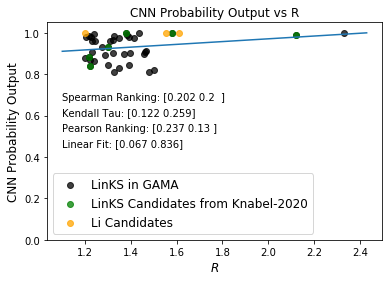

In [126]:
# CNN probability scores vs R

spear = np.around(stats.spearmanr(samples.cnn_probability, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.R)[:], 3)

# fit a line
model = np.polyfit(samples.R, samples.cnn_probability, 1)
x = np.linspace(np.min(samples.R) - 0.1, np.max(samples.R) + 0.1, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.R,
          #links.sigma2,
    links_selected_sample.cnn_probability,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.R,
           #links_knabel.sigma2,
    links_knabel_selected_sample.cnn_probability,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(li_selected_sample.R,
           #li.sigma2,
    li_selected_sample.cnn_probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman Ranking: {spear}', (1.1, 0.675))
plt.annotate(f'Kendall Tau: {kendall}', (1.1, 0.6))
plt.annotate(f'Pearson Ranking: {pears}', (1.1, 0.525))
plt.annotate(f'Linear Fit: {np.around(model, 3)}', (1.1, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$R$',  fontsize = 12)
ax.set_title('CNN Probability Output vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}cnn_score_to_R_011821.png')

[array([0.202, 0.2  ]), array([0.237, 0.13 ]), array([0.122, 0.259]), array([0.06708982, 0.83639289])]
mean, std 0.0645521959490423 0.029991238350004196
mean, std 0.8396177790292447 0.04191753227125693


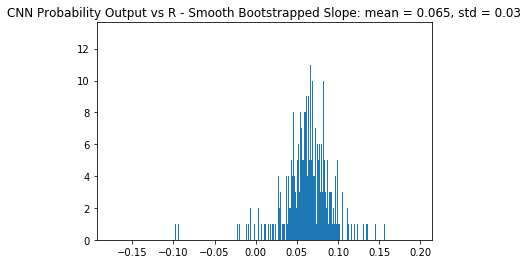

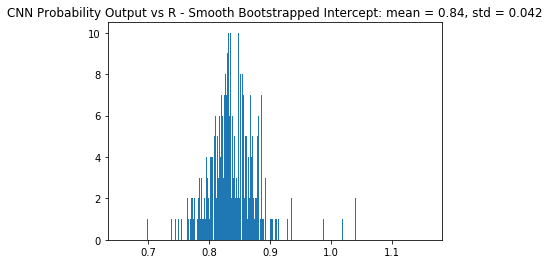

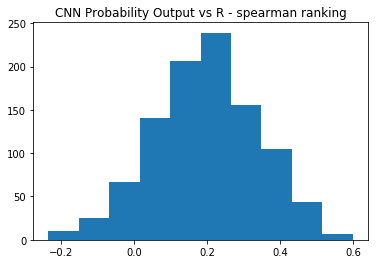

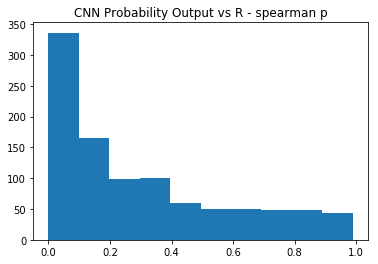

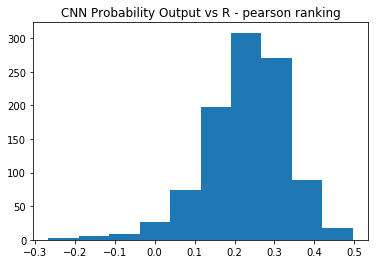

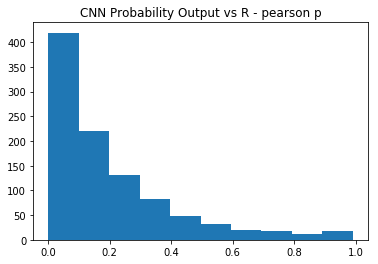

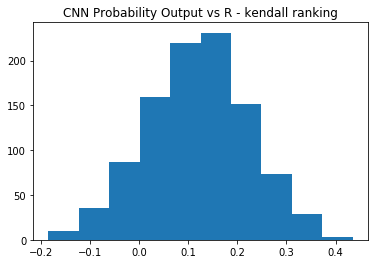

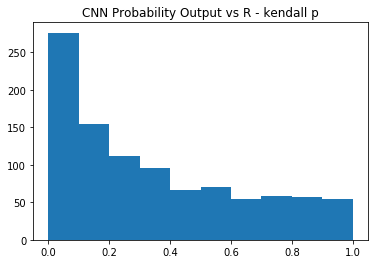

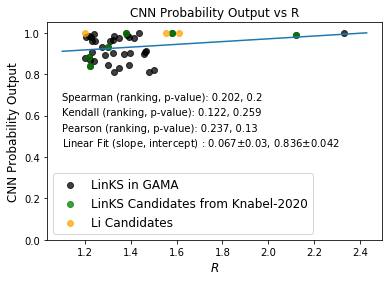

In [127]:
# run bootstrapping to see how the rankings change for cnn_probability to sigma2 and R
# R

# create array to show stats (columns=spearman ranking, p,pearson ranking, p,kendall ranking, p), 43 iterations
bootstrapping_R = np.zeros((1000, 8), dtype=float)

#print(bootstrapping_R)

spear = np.around(stats.spearmanr(samples.cnn_probability, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.R)[:], 3)
linear = np.polyfit(samples.R, samples.cnn_probability, 1)

full_sample=[spear, pears, kendall, linear]
print(full_sample)

# take random samples of 30, omit 12 and replace with values from the 30
for i in range(1000):
    # shuffle the sample
    indices = np.arange(len(samples))
    #print(indices)
    np.random.shuffle(indices)
    #print(indices)
    subsample_index = indices[:30]
    #print(len(np.unique(subsample_index)))
    bootstrap_index = np.random.choice(subsample_index, 12) # subsample 13 from subsample
    new_sample_index = np.concatenate((subsample_index, bootstrap_index)) # concat to new sample
    new_sample = samples.iloc[new_sample_index]
    # smooth x-values (R) using random gaussian
    #print(new_sample.R)
    #print(new_sample)
    
    # run tests
    spear = np.around(stats.spearmanr(new_sample.cnn_probability, new_sample.R)[:], 3)
    pears = np.around(stats.pearsonr(new_sample.cnn_probability, new_sample.R)[:], 3)
    kendall = np.around(stats.kendalltau(new_sample.cnn_probability, new_sample.R)[:], 3)
    linear = np.around(np.polyfit(new_sample.R, new_sample.cnn_probability, 1)[:], 3)
    #print(linear)
    #print(new_sample[['R', 'cnn_probability']])
    #print(linear)
    bootstrapping_R[i] = (spear[0], spear[1], 
                               pears[0], pears[1], 
                               kendall[0], kendall[1],
                              linear[0], linear[1])
    smoothed_slopes = bootstrapping_R[:,6] + np.random.normal(loc=0.0, scale=0.001, size=1000)
    smoothed_intercepts = bootstrapping_R[:,7] + np.random.normal(loc=0.0, scale=0.001, size=1000) 
#print(bootstrapping_R)
#print(bootstrapping_R[:,6:])
fig, ax = plt.subplots()
ax.hist(smoothed_slopes, bins=1000)#, normed=True)
ax.set_title(f'CNN Probability Output vs R - Smooth Bootstrapped Slope: mean = {np.around(np.mean(smoothed_slopes), 3)}, std = {np.around(np.std(smoothed_slopes), 3)}')
print('mean, std', np.mean(smoothed_slopes), np.std(smoothed_slopes))
fig, ax = plt.subplots()
ax.hist(smoothed_intercepts, bins=1000)
ax.set_title(f'CNN Probability Output vs R - Smooth Bootstrapped Intercept: mean = {np.around(np.mean(smoothed_intercepts), 3)}, std = {np.around(np.std(smoothed_intercepts), 3)}')
print('mean, std', np.mean(smoothed_intercepts), np.std(smoothed_intercepts))

plt.figure()
plt.hist(bootstrapping_R[:,0], bins = 10)
plt.title('CNN Probability Output vs R - spearman ranking')
plt.figure()
plt.hist(bootstrapping_R[:,1], bins=10)
plt.title('CNN Probability Output vs R - spearman p')
plt.figure()
plt.hist(bootstrapping_R[:,2], bins = 10)
plt.title('CNN Probability Output vs R - pearson ranking')
plt.figure()
plt.hist(bootstrapping_R[:,3], bins=10)
plt.title('CNN Probability Output vs R - pearson p')
plt.figure()
plt.hist(bootstrapping_R[:,4], bins = 10)
plt.title('CNN Probability Output vs R - kendall ranking')
plt.figure()
plt.hist(bootstrapping_R[:,5], bins=10)
plt.title('CNN Probability Output vs R - kendall p')


# CNN probability scores vs R

spear = np.around(stats.spearmanr(samples.cnn_probability, samples.R)[:], 3)
pears = np.around(stats.pearsonr(samples.cnn_probability, samples.R)[:], 3)
kendall = np.around(stats.kendalltau(samples.cnn_probability, samples.R)[:], 3)

# fit a line
model = np.polyfit(samples.R, samples.cnn_probability, 1)
x = np.linspace(np.min(samples.R) - 0.1, np.max(samples.R) + 0.1, num=100)

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.R,
          #links.sigma2,
    links_selected_sample.cnn_probability,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.R,
           #links_knabel.sigma2,
    links_knabel_selected_sample.cnn_probability,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(li_selected_sample.R,
           #li.sigma2,
    li_selected_sample.cnn_probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')
ax.plot(x, model[0]*x + model[1])

plt.annotate(f'Spearman (ranking, p-value): {spear[0]}, {spear[1]}', (1.1, 0.675))
plt.annotate(f'Kendall (ranking, p-value): {kendall[0]}, {kendall[1]}', (1.1, 0.6))
plt.annotate(f'Pearson (ranking, p-value): {pears[0]}, {pears[1]}', (1.1, 0.525))
plt.annotate(f'Linear Fit (slope, intercept) : {np.around(model[0], 3)}$\\pm${np.around(np.std(smoothed_slopes), 3)}, '\
                f'{np.around(model[1], 3)}$\\pm${np.around(np.std(smoothed_intercepts), 3)}', (1.1, 0.45))

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$R$',  fontsize = 12)
ax.set_title('CNN Probability Output vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig(f'{png_path}cnn_score_to_R_012121.png')

In [128]:
# z1, z2, mass, type?
#from mpl_toolkits.mplot3d import Axes

#fig = plt.figure(figsize=(8,8))
#ax = plt.axes(projection='3d')
#ax.set_zlim(0, 12)
#ax.scatter3D(xs=spec.lambdar_log_mstar, ys=spec.z_lens, zs=spec.theta_e_pm/spec.theta_e_sis,
          #label='GAMA Spectroscopy Candidates',
          #color = 'b')

#ax.set_xticks(np.arange(10**9, 10**12, 10**11))
#ax.set_xticks(labels=None)
#for label in ax.get_xticklabels():
#    label.set_visible(False)
#ax.set_ylabel('Lens Redshift')
#ax.set_zlabel('Ratio of Estimates $\Theta_{E,TL}/\Theta_{E,SIS}$')
#ax.view_init(0, 90)

In [129]:
# look at links candidates that would have passed the sigma2-R criteria, most likely not pg-elg
pesky_ones = links_selected_sample[links_selected_sample.R > 1.85]
print(pesky_ones.columns)
pesky_ones.iloc[0][['GAMA_ID','lambdar_log_mstar','z1','sigma1','template1','z2','sigma2','template2','R']]
# So 544226 should totally have been identified by Holwerda2015
#pesky_ones.to_csv(f'{csv_path}links_candidates_in_hol15_selection_space.csv')


Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass', 'P1', 'P3', 'normalized_score',
       'cnn_probability'],
      dtype='object')


GAMA_ID                544226
lambdar_log_mstar     11.2852
z1                   0.227044
sigma1                9.39305
template1                  40
z2                   0.649824
sigma2                 7.2399
template2                  46
R                     2.12217
Name: 11, dtype: object

In [130]:
# load in holwerda2015
spec = pd.read_csv(f'{knabel2020_file_path}final_sample.csv')
print(np.sort(spec.cataid))

[   7242   14983   15221   15554   22278   22559   48883   65298   71072
   77892   98399   98624   99508  106821  130303  131725  136800  164640
  185604  198082  202448  204140  209222  209295  209584  220682  220854
  231043  231307  231746  238715  239367  250209  250487  251342  273903
  279956  289278  298899  301818  302719  319348  319416  320384  320557
  323200  323247  325026  325108  342308  371208  377212  377486  380839
  382857  383284  388201  402278  417645  419678  422882  460463  460713
  485756  508116  560475  560853  573657  574390  575653  583469  586392
  586648  610029  617535  617856  663372  690020  814991  905359 1126606
 1270758 1312058 1569977 1684064 1763319 2005629 2248952 3576902 3626956
 3632403 3884455 3909630 5000687 5014213 5022159 5026858 5108875 5133005
 5137833 5151434 5196710 5205278 5229802 5230798 5247328 5251563 5265318
 5278488 5287452 5287619 5297680 5305885 5327168 5363861 7021723 7028850
 7035191 7056621 7061088 7081863 7083868]


In [131]:
# does it fall on an alias?
#All candidates, old and new, near the alias of
#(1+z)/(1+z2)=1.343±0.002 (∼5007/3727) or the inversewere removed from the sample

z1 = pesky_ones.iloc[0].z1
z2 = pesky_ones.iloc[0].z2

print((z1+1)/(z2+1), (z2+1)/(z1+1))


0.7437427132310329 1.3445509881444238


### That is precisely what happened.

# Checking zlens against z from catalog. (autoz is considered the best, so it's back to looking at sigma1 and sigma2...)

In [132]:
print(links_selected_sample.columns, links_knabel_selected_sample.columns, li_selected_sample.columns)
#print(li_selected_sample[['zlens','zsource','z','type']])
#print(links_selected_sample[['zlens','zsource','z','type']])
samples_redshifts = samples[['zlens','zsource','z1','sigma1','z2','sigma2','z','type']]
samples_redshifts

Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'type_number',
       'lambdar_log_mstar', 'lambdar_mstar', 'lambdar_log_mstar_error', 'z',
       'zlens', 'zsource', 'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass', 'P1', 'P3', 'normalized_score',
       'cnn_probability'],
      dtype='object') Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'GAMA_ID', 'RA', 'DEC', 'score', 'z',
       'magphys_mstar', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'm_half_re', 'sigma_star', 'D_lens',
       'theta_e_pm', 'theta_e_sis', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'type_number', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass', 'ID', 'P

,zlens,zsource,z1,sigma1,z2,sigma2,z,type
0,0.243359,0.634666,0.243359,10.951900,0.634666,3.553775,0.24336,PG + ELG
1,0.187679,0.763765,0.187679,11.541553,0.763765,4.008492,0.18776,PG + ELG
2,0.217723,0.712327,0.217723,12.368897,0.712327,3.347791,0.21772,PG + ELG
3,0.231903,0.771556,0.231903,9.052866,0.771556,4.793196,0.23190,PG + ELG
4,0.383991,0.837412,0.383991,8.714600,0.837412,4.373900,0.38411,PG + ELG
5,0.204663,0.788741,0.204663,11.430782,0.788741,3.371675,0.20466,PG + ELG
6,0.320287,0.855552,0.320287,9.753261,0.855552,3.635149,0.32019,PG + ELG
7,0.285867,0.673673,0.285867,12.257433,0.673673,3.122599,0.28587,PG + ELG
8,0.259462,0.870761,0.259462,9.833871,0.870761,3.698742,0.25946,PG + ELG
9,0.250201,0.713636,0.250201,9.004106,0.713636,3.653380,0.25020,PG + ELG


In [133]:
samples_matchedtosource = samples_redshifts[(abs(samples_redshifts.zsource - samples_redshifts.z1) < 0.01)]
samples_matchedtosource

,zlens,zsource,z1,sigma1,z2,sigma2,z,type
18,0.353286,0.721590,0.721590,11.317520,0.353286,7.519264,NaN,PG + ELG
19,0.232537,0.365195,0.365195,8.068478,0.232537,4.330916,0.36519,ELG + PG
20,0.084084,0.359895,0.359895,7.316126,0.084084,3.734915,0.35945,ELG + PG
21,0.069276,0.338887,0.338887,7.433445,0.069276,5.039492,0.33889,ELG + PG
22,0.153366,0.307835,0.307835,10.453988,0.153366,4.026956,0.30790,ELG + PG
23,0.156429,0.390652,0.390652,10.292731,0.156429,9.673656,0.39032,ELG + PG
24,0.144270,0.418365,0.418365,10.226271,0.144270,3.869574,0.41836,ELG + PG
25,0.071459,0.438321,0.438321,10.446877,0.071459,4.822088,0.43832,ELG + PG
33,0.204727,0.416539,0.416539,5.481457,0.204727,3.713554,0.41641,ELG + ELG
40,0.079985,0.449927,0.449927,10.597881,0.079985,6.895601,0.44993,ELG + ELG


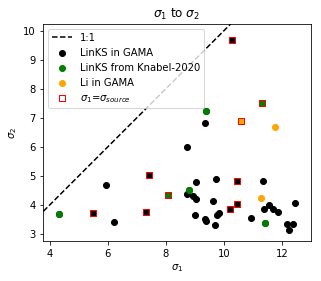

In [134]:
fig, ax = plt.subplots()
ax.scatter(links_selected_sample.sigma1, links_selected_sample.sigma2, 
           color='k',
          label='LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.sigma1, links_knabel_selected_sample.sigma2, 
           color='g',
          label='LinKS from Knabel-2020')
ax.scatter(li_selected_sample.sigma1, li_selected_sample.sigma2,
          color='orange',
          label='Li in GAMA')
ax.scatter(samples_matchedtosource.sigma1, samples_matchedtosource.sigma2, 
           facecolor='none',edgecolor='r', marker='s',
          label='$\sigma_1$=$\sigma_{source}$')
x = np.linspace(3, 13, 10)
ax.plot(x, x, color='k', linestyle='--', label='1:1')

ax.set_aspect(1)
ax.set_title('$\sigma_1$ to $\sigma_2$')
ax.set_xlabel('$\sigma_1$')
ax.set_ylabel('$\sigma_2$')
ax.set_xlim(3.75, 13)
ax.set_ylim(2.75, 10.25)
ax.legend()
#plt.savefig(f'{png_path}samples_sigma2_to_sigma1_012121.png')

In [135]:
samples_matchedtosource.sigma1/samples_matchedtosource.sigma2

18    1.505137
19    1.862995
20    1.958847
21    1.475039
22    2.596003
23    1.063996
24    2.642738
25    2.166463
33    1.476068
40    1.536905
dtype: float64

In [136]:
samples[['GAMA_ID','z1','z2','template1','template2','type']]

,GAMA_ID,z1,z2,template1,template2,type
0,600305.0,0.243359,0.634666,40.0,45.0,PG + ELG
1,419067.0,0.187679,0.763765,40.0,43.0,PG + ELG
2,387244.0,0.217723,0.712327,40.0,47.0,PG + ELG
3,3611088.0,0.231903,0.771556,40.0,43.0,PG + ELG
4,373093.0,0.383991,0.837412,40.0,43.0,PG + ELG
5,585328.0,0.204663,0.788741,40.0,43.0,PG + ELG
6,561058.0,0.320287,0.855552,40.0,43.0,PG + ELG
7,84425.0,0.285867,0.673673,40.0,43.0,PG + ELG
8,165293.0,0.259462,0.870761,40.0,43.0,PG + ELG
9,559216.0,0.250201,0.713636,40.0,45.0,PG + ELG
